In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import pickle

In [17]:
from data_util.load_data import load_image_pix_mask, load_rf_gaussian_fits, load_cell_ordering, \
    load_typed_dataset, make_glm_stim_time_component
from data_util.load_models import load_fitted_glm_families, separate_coupling_filters_by_type_and_id, \
    extract_glm_parameters_for_cell
from notebook_graphics.plot_notebook_graphics import plot_rgc_mosaics

In [6]:
mpl.rcParams['figure.dpi'] = 75

# Demonstration notebook for "Maximum a posteriori natural scene reconstruction from retinal ganglion cells with deep denoiser priors"

This notebook explores the experimental dataset and explains how to run the demonstration code for generating natural scenes reconstructions.

#### Requirements:
1. Python >= 3.8
2. pytorch, numpy, scipy, matplotlib, shapely, tqdm
3. NVIDIA GPU strongly recommended


In [7]:
pix_mask = load_image_pix_mask()

In [8]:
glm_stim_time_component = make_glm_stim_time_component()

## Explore the dataset

First load the data structure that tells us what cells are in the dataset

In [9]:
cells_ordered = load_cell_ordering()

Then load the spikes and stimuli

In [10]:
frames, spikes_dict = load_typed_dataset()

#### RGC mosaics

The four major ganglion cell types in the primate retina are ON parasols, OFF parasols, ON midgets, and OFF midgets. ON cells respond (spike) in response to increments in luminance (stimulus gets brighter) while OFF cells respond to decrements in luminance (stimulus gets darker). Parasol RGCs have larger receptive fields (they respond to light in a larger patch of stimulus space) than midget RGCs. Midget RGCs are much more numerically dominant than parasol RGCs

Each of the RGC types are known to uniformly tile stimulus space, and a complete mosaic of a given RGC type should uniformly sample stimulus space.

In [11]:
rf_gaussian_fits = load_rf_gaussian_fits()

Below, we plot the receptive field mosaics of all of the cells used for one of the retinas. The shaded blue region corresponds to the region with sufficient coverage of cells, and is the region over which the evaluation metrics in the paper were computed.

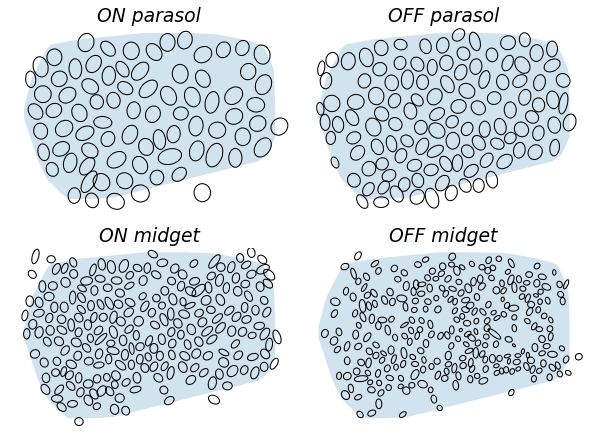

In [12]:
plot_rgc_mosaics(cells_ordered, rf_gaussian_fits, pix_mask)

#### Stimulus trial design and rasters

Each stimulus trial consisted of a image that was statically flashed for 100 ms, and then the display was returned to gray. The RGC responses that occurred in the 150 ms window immediately after the onset of the stimulus (shaded blue in the figure below) were used to perform the reconstruction. This window corresponds approximately to the "onset" response of the cells (i.e. when cells respond to the change in luminance due to the display transition from gray to image).

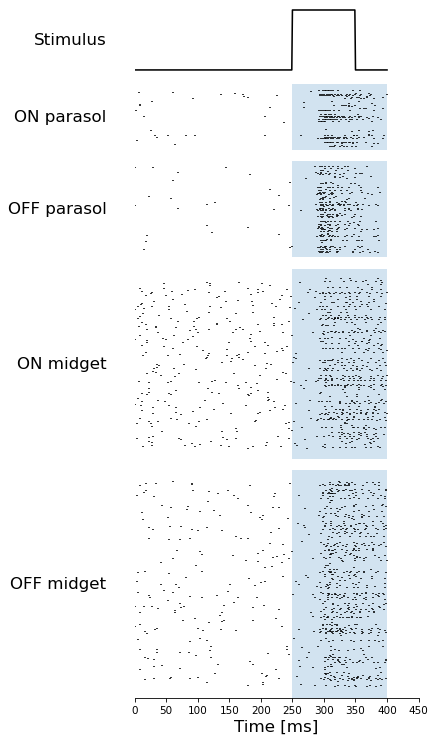

In [13]:
TRIAL_IDX = 1
MAX_SAMPLE = 450

fig = plt.figure(figsize=(6, 10))

gs = fig.add_gridspec(5, 1, height_ratios=(79, 79, 115, 228, 273))


for ax_ix, cell_type in zip([1, 2, 3, 4], ['ON parasol', 'OFF parasol', 'ON midget', 'OFF midget']):
    raster_ax = fig.add_subplot(gs[ax_ix])
    responses = spikes_dict[cell_type][TRIAL_IDX, ...]
    spike_locations = np.argwhere(responses)

    event_acc = []
    for i in range(responses.shape[0]):
        event_acc.append(spike_locations[spike_locations[:,0] == i][:, 1])
    raster_ax.eventplot(event_acc, color='black')
    raster_ax.set_xlim([0, MAX_SAMPLE])

    raster_ax.spines['top'].set_visible(False)
    raster_ax.spines['right'].set_visible(False)
    raster_ax.spines['bottom'].set_visible(False) #
    raster_ax.spines['left'].set_visible(False)
    raster_ax.yaxis.set_visible(False)
    raster_ax.xaxis.set_visible(False)
    #raster_ax.set_xlabel('Time [ms]', fontsize=18)
    raster_ax.annotate(cell_type, xy=(-0.1, 0.5), xytext=(0, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=16, ha='right', va='center', color='black')
    raster_ax.axvspan(250, 250 + 150, alpha=0.2)
raster_ax.xaxis.set_visible(True)
raster_ax.spines['bottom'].set_visible(True)
raster_ax.set_xlabel('Time [ms]', fontsize=16)
ax2 = fig.add_subplot(gs[0], sharex=raster_ax)

ax2.plot(glm_stim_time_component, color='black')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax2.annotate('Stimulus', xy=(-0.1, 0.5), xytext=(0, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=16, ha='right', va='center', color='black')

plt.tight_layout()

plt.show()

## Show example GLM parameters for one cell

The generalized linear model (GLM) for a RGC has the following parameters:
1. Stimulus spatial and temporal filters, used to model the response of the RGC to light
2. Feedback (post-spike) filter, used to represent the refractory period and other temporal structure in the spike train
3. Coupling filters to the observed spikes of nearby cells, used to model correlated spiking between different RGCs

In our implementation of the GLM, we bin spikes into 1 ms time bins, corresponding approximately to the refractory period of a RGC. All of the filters (stimulus temporal, feedback, and coupling) are causal in time. We use a sigmoidal nonlinearity and Bernoulli random spiking.

A schematic of our GLM implementation is provided below:

<img src="notebook_graphics/images/glm_schematic.svg" width="500"/>

Let's plot GLM fits from real data for a real cell. We choose an example ON parasol.

In [14]:
fitted_glm_families = load_fitted_glm_families()

In [15]:
CENTER_ID = 445
CENTER_TYPE = 'ON parasol'

In [18]:
spatial_filter, bias, time_filter, feedback_filter, coupling_filters, coupling_ids = extract_glm_parameters_for_cell(
    CENTER_TYPE, 
    CENTER_ID, 
    fitted_glm_families)

Below, from left to right: (1) The spatial component of the stimulus filter for the ON parasol; (2) the temporal component of the stimulus spatial filter; (3) The feedback filter.

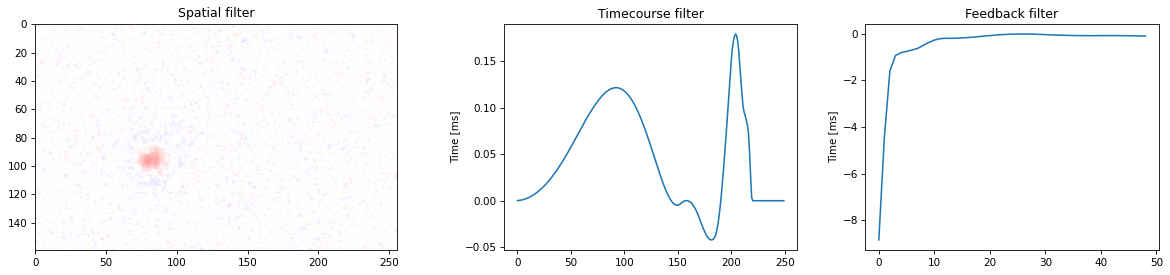

In [19]:
fig = plt.figure(figsize=(20, 4))
gs = fig.add_gridspec(1, 3, width_ratios=(1.5, 1, 1))

spat_filt_axis = fig.add_subplot(gs[0])
spat_filt_axis.set_title("Spatial filter")
spat_filt_axis.imshow(spatial_filter, vmin=-0.05, vmax=0.05, cmap='bwr')

timecourse_axis = fig.add_subplot(gs[1])
timecourse_axis.set_title("Timecourse filter")
timecourse_axis.set_ylabel('Time [ms]')
timecourse_axis.plot(time_filter.squeeze())

feedback_axis = fig.add_subplot(gs[2])
feedback_axis.set_title("Feedback filter")
feedback_axis.plot(feedback_filter.squeeze()[:200:-1])
feedback_axis.set_ylabel('Time [ms]')
plt.show()

In [21]:
coupling_filters_by_type_and_id = separate_coupling_filters_by_type_and_id(coupling_filters, coupling_ids, cells_ordered)

Below, the coupling filters, arranged by the type of the coupling cell. In each of the top panels, the ON parasol being fit is drawn in gray, and each coupled cell is color-coded with its corresponding coupling filter. Note that because of the L21 group sparsity penalty when fitting the GLM, most of the coupling filters are zero.

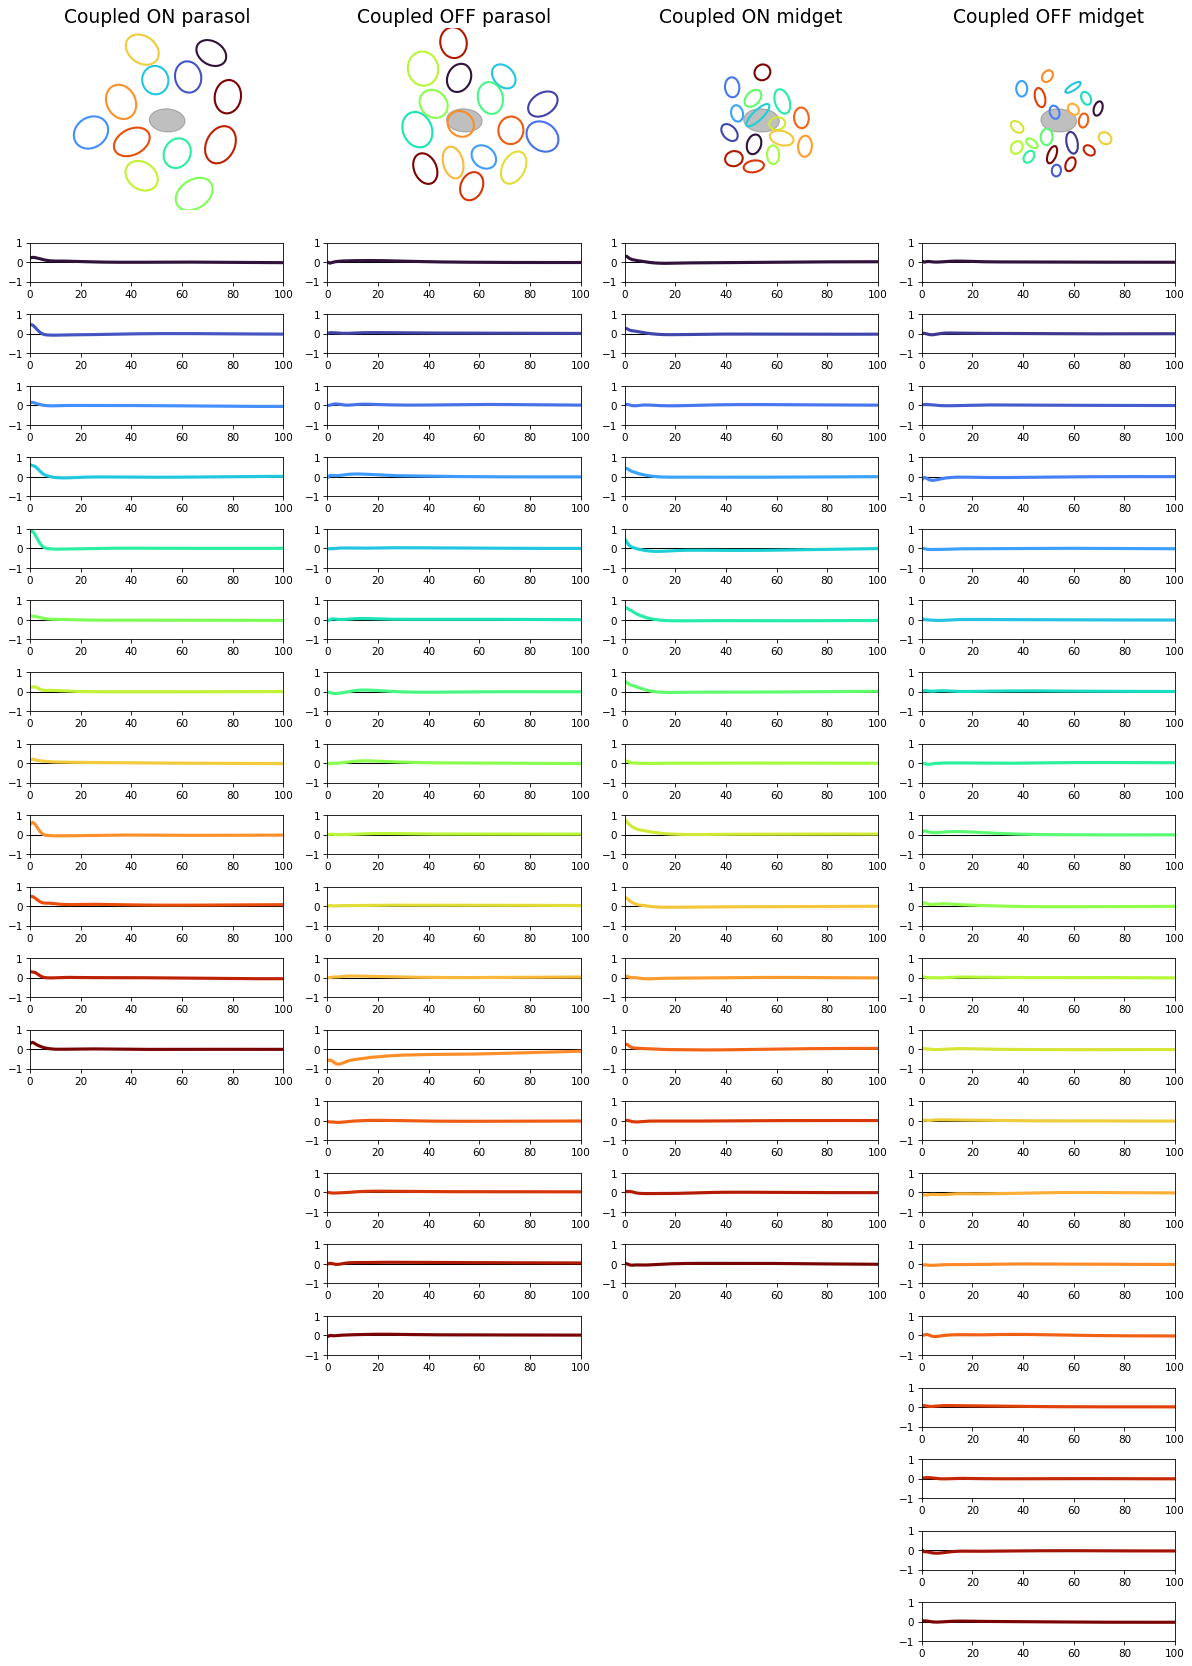

In [22]:
from matplotlib.patches import Ellipse

NUM_SIGMAS_RFFIT = 2

DISPLAY_LOW_X, DISPLAY_HIGH_X = 15, 40
DISPLAY_LOW_Y, DISPLAY_HIGH_Y = 0, 32

fig = plt.figure(figsize=(16, 24))
gs = fig.add_gridspec(25, 4, width_ratios=(1, 1, 1, 1))

for kk, cell_type in enumerate(['ON parasol', 'OFF parasol', 'ON midget', 'OFF midget']):
    
    rf_axis = fig.add_subplot(gs[0:3, kk])
    rf_axis.axis('equal')
    rf_axis.axis('off')

    sta_fit = rf_gaussian_fits[CENTER_ID]

    mu_x = sta_fit.center_x
    mu_y = sta_fit.center_y
    sigma_x = -sta_fit.std_y
    sigma_y = sta_fit.std_x

    degrees = sta_fit.rot * (180 / np.pi) * -1
    fit = Ellipse(xy=(mu_x, mu_y), width=NUM_SIGMAS_RFFIT * sigma_y,
                  height=NUM_SIGMAS_RFFIT * sigma_x,
                  angle=degrees)
    fit.set_alpha(0.25)
    fit.set_facecolor('black')
    fit.set_edgecolor('black')
    rf_axis.add_artist(fit)
    
    rf_axis.set_title(f'Coupled {cell_type}', fontsize=18)

    n_coupled_cells = len(list(coupling_filters_by_type_and_id[cell_type].keys()))
    
    scatter_cmap = plt.cm.get_cmap("turbo")
    scatter_colors = [scatter_cmap(i) for i in np.linspace(0, 1, n_coupled_cells)]
    
    for axis_step_count, cell_id in enumerate(coupling_filters_by_type_and_id[cell_type].keys()):
        sta_fit = rf_gaussian_fits[cell_id]

        mu_x = sta_fit.center_x
        mu_y = sta_fit.center_y
        sigma_x = -sta_fit.std_y
        sigma_y = sta_fit.std_x

        degrees = sta_fit.rot * (180 / np.pi) * -1
        fit = Ellipse(xy=(mu_x, mu_y), width=NUM_SIGMAS_RFFIT * sigma_y,
                      height=NUM_SIGMAS_RFFIT * sigma_x,
                      angle=degrees)

        fit.set_alpha(1)
        fit.set_facecolor('none')
        fit.set_edgecolor(scatter_colors[axis_step_count])
        fit.set_linewidth(2.0)
        rf_axis.add_artist(fit)

        rf_axis.set_xlim([DISPLAY_LOW_X, DISPLAY_HIGH_X])
        rf_axis.set_ylim([DISPLAY_LOW_Y, DISPLAY_HIGH_Y])

        stepped_axis_ix = axis_step_count + 3
        coupling_filter_axis = fig.add_subplot(gs[stepped_axis_ix, kk])
        coupling_filter_axis.axhline(y=0, color='k', lw=1.0)
        coupling_filter_axis.plot(coupling_filters_by_type_and_id[cell_type][cell_id][:100:-1], 
                                  c=scatter_colors[axis_step_count], lw=3.0)
        coupling_filter_axis.set_ylim([-1.0, 1.0])
        coupling_filter_axis.set_xlim([0, 100])
        
plt.tight_layout()
    
plt.show()

## Generate and plot test reconstructions

In [2]:
!mkdir -p OUTPUT_RECONSTRUCTIONS

#### Generate MAP-GLM-dCNN and MAP-LNP-dCNN reconstructions

In [3]:
!python generate_MAP_GLM_dCNN_recons.py OUTPUT_RECONSTRUCTIONS/map_glm_dCNN.p -gpu -l
!python generate_MAP_LNP_dCNN_recons.py OUTPUT_RECONSTRUCTIONS/map_lnp_dCNN.p -gpu

Generating MAP-GLM-dCNN reconstructions
100%|███████████████████████████████████████████| 21/21 [00:42<00:00,  2.04s/it]
done
Generating MAP-LNP-dCNN reconstructions
100%|███████████████████████████████████████████| 21/21 [01:07<00:00,  3.22s/it]
done


#### Generate MAP-GLM-1F reconstructions

In [5]:
!python generate_MAP_GLM_1F_recons.py OUTPUT_RECONSTRUCTIONS/map_glm_1f.p -gpu

Computing Fourier outer product
100%|███████████████████████████████████████████| 21/21 [05:01<00:00, 14.36s/it]
done


#### Generate the benchmark reconstructions

In [6]:
!python generate_lcae_recons.py OUTPUT_RECONSTRUCTIONS/lcae.p -gpu
!python generate_kim_recons.py OUTPUT_RECONSTRUCTIONS/kim.p -gpu

done
done


#### Load all of the reconstructions

In [23]:
with open('OUTPUT_RECONSTRUCTIONS/map_glm_dCNN.p', 'rb') as pfile:
    temp = pickle.load(pfile)
    ground_truth = temp['ground_truth']
    map_glm_dcnn = temp['glm_hqs']
    
with open('OUTPUT_RECONSTRUCTIONS/map_lnp_dCNN.p', 'rb') as pfile:
    temp = pickle.load(pfile)
    map_lnp_dcnn = temp['lnp_hqs']
    
with open('OUTPUT_RECONSTRUCTIONS/map_glm_1f.p', 'rb') as pfile:
    temp = pickle.load(pfile)
    map_glm_1f = temp['MAP_GLM_1F']
    
with open('OUTPUT_RECONSTRUCTIONS/kim.p', 'rb') as pfile:
    temp = pickle.load(pfile)
    kim_recons = temp['kim_post_deblur']
    
with open('OUTPUT_RECONSTRUCTIONS/lcae.p', 'rb') as pfile:
    temp = pickle.load(pfile)
    linear_recons = temp['linear']
    lcae_recons = temp['autoencoder']

#### Plot all of the reconstructions

In [24]:
mpl.rcParams['figure.dpi'] = 300

findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


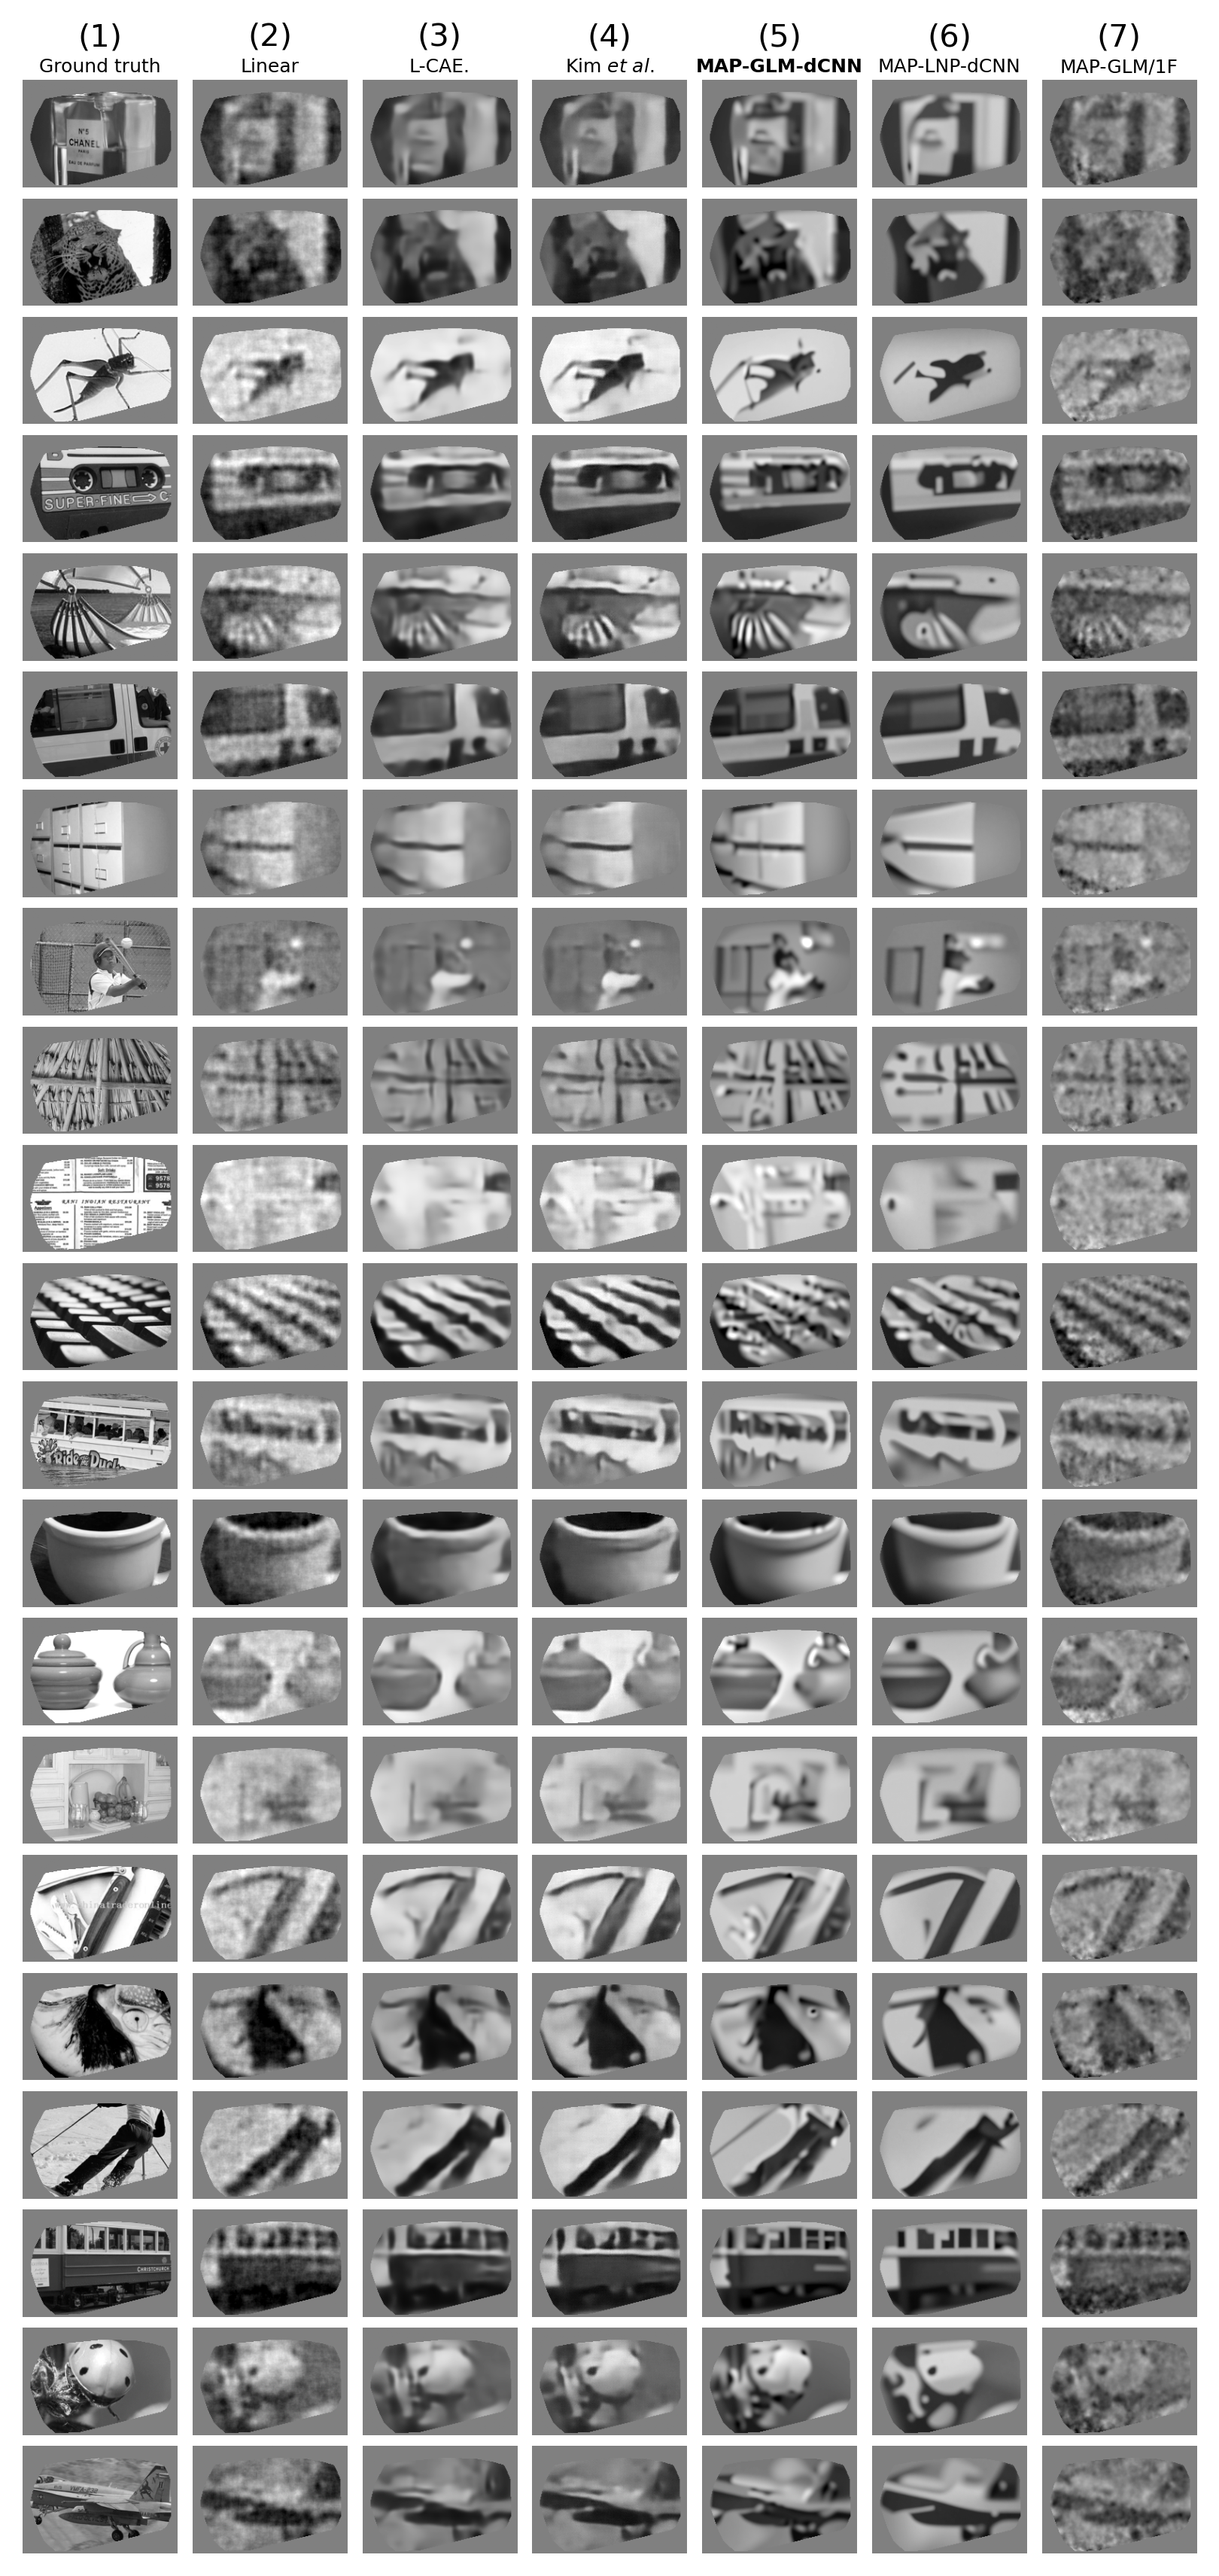

In [25]:
N_ROWS = ground_truth.shape[0]
N_COLS = 7 # will be 7 later
AS_WRITTEN_SIZE = np.array((1.8 * N_COLS, 1.25 * N_ROWS))

NEURIPS_WIDTH_INCHES = 5.5

TRUE_SIZE = NEURIPS_WIDTH_INCHES * AS_WRITTEN_SIZE / (AS_WRITTEN_SIZE[0])
fig, axes = plt.subplots(N_ROWS, N_COLS,
                         figsize=TRUE_SIZE)
for row_ix in range(N_ROWS):
    
    ax = axes[row_ix, 0]
    ax.imshow(pix_mask[10:, 10:-30] * ground_truth[row_ix,10:,10:-30], cmap='gray', vmin=-1.0, vmax=1.0)
    ax.axis('off')
    if row_ix == 0:
        ax.set_title('Ground truth', fontsize=6, y=0.9)
    
    ax = axes[row_ix, 1]
    ax.imshow(pix_mask[10:, 10:-30] * linear_recons[row_ix,10:, 10:-30], cmap='gray', vmin=-1.0, vmax=1.0)
    ax.axis('off')
    if row_ix == 0:
        ax.set_title('Linear', fontsize=6, y=0.9)
        
    ax = axes[row_ix, 2]
    ax.imshow(pix_mask[10:, 10:-30] * lcae_recons[row_ix,10:, 10:-30], cmap='gray', vmin=-1.0, vmax=1.0)
    ax.axis('off')
    if row_ix == 0:
        ax.set_title('L-CAE.', fontsize=6, y=0.9)
        
    ax = axes[row_ix, 3]
    ax.imshow(pix_mask[10:, 10:-30] * kim_recons[row_ix,10:, 10:-30], cmap='gray', vmin=-1.0, vmax=1.0)
    ax.axis('off')
    if row_ix == 0:
        ax.set_title('Kim $\it{et}$ $\it{al.}$', fontsize=6, y=0.9)
        
    ax = axes[row_ix, 4]
    ax.imshow(pix_mask[10:, 10:-30] * map_glm_dcnn[row_ix,10:, 10:-30], cmap='gray', vmin=-1.0, vmax=1.0)
    ax.axis('off')
    if row_ix == 0:
        ax.set_title('MAP-GLM-dCNN', fontsize=6, fontweight="bold", y=0.9)
        
    ax = axes[row_ix, 5]
    ax.imshow(pix_mask[10:, 10:-30] * map_lnp_dcnn[row_ix,10:, 10:-30], cmap='gray', vmin=-1.0, vmax=1.0)
    ax.axis('off')
    if row_ix == 0:
        ax.set_title('MAP-LNP-dCNN', fontsize=6, y=0.9)
        
    ax = axes[row_ix, 6]
    ax.imshow(pix_mask[10:, 10:-30] * map_glm_1f[row_ix,10:, 10:-30], cmap='gray', vmin=-1.0, vmax=1.0)
    ax.axis('off')
    if row_ix == 0:
        ax.set_title('MAP-GLM/1F', fontsize=6, y=0.9)
        
for col, ax in enumerate(axes[0,:]):
    ax.annotate(f'({col+1})', xy=(0.5, 1.4), xytext=(0, 0),
               xycoords='axes fraction', textcoords='offset points',
                size=10, ha='center', va='center', color='black')
   
plt.tight_layout()

plt.subplots_adjust(wspace=0.1, hspace=0.1)

    
plt.show()